# Test LT maps

### Author: JJGC

### Software: KrCalib : https://github.com/nextic/KrCalib/

In [1]:
%load_ext autoreload
%autoreload 2
import os
import time
import datetime 
print("Last updated on ", time.asctime())

Last updated on  Sun Sep  2 12:41:09 2018


In [124]:
import logging
import sys

logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s',
                     level=logging.INFO, stream=sys.stdout)

logging.info('Hello world!')



2018-09-02 16:30:53,361 | INFO : Hello world!


In [72]:
from krcal.core.kr_types import KrFileName
input_path  = f"$IC_DATA/dst"
output_path = f"$IC_DATA/ldst"
map_path    = f"$IC_DATA/maps"

input_file_names  = ['dst_6284_trigger1_0000_7920.h5']
output_file_name  = ' '
map_file_name     = ' '
map_file_name_ts  = ' '
emap_file_name    = ' '


krfn = KrFileName(input_file_names,
                  output_file_name,
                  map_file_name,
                  map_file_name_ts,
                  emap_file_name)

In [73]:
%matplotlib inline
import matplotlib.pyplot as plt

from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection

plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

In [74]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib
import tables            as tb
import random
import glob
import warnings
sns.set()

### Imports from IC

In [91]:
from  invisible_cities.io.dst_io              import load_dsts
from  invisible_cities.core .core_functions   import in_range
from krcal.core.core_functions      import time_delta_from_time
from krcal.core.core_functions      import phirad_to_deg
from krcal.core.core_functions      import NN
from krcal.core                     import fit_functions_ic as fitf

In [76]:
from krcal.core.io_functions       import kdst_write
from krcal.core.io_functions       import filenames_from_list
from krcal.core.io_functions       import write_maps
from krcal.core.io_functions       import read_maps
from krcal.core.io_functions       import write_maps_ts
from krcal.core.io_functions       import read_maps_ts

In [77]:
from krcal.core.histo_functions    import h1, h1d, h2, h2d, plot_histo

In [78]:
from krcal.core.analysis_functions  import kr_ranges_and_bins
from krcal.core.analysis_functions  import fiducial_volumes
from krcal.core.analysis_functions  import fid_eff
from krcal.core.analysis_functions  import select_rphi_sectors
from krcal.core.analysis_functions  import select_xy_sectors
from krcal.core.analysis_functions  import event_map
from krcal.core.analysis_functions  import plot_sector
from krcal.core.analysis_functions  import plot_sectors
from krcal.core.analysis_functions  import kr_event_selection
from krcal.core.analysis_functions  import kr_event

In [94]:
from krcal.core.fit_lt_functions    import fit_lifetime
from krcal.core.fit_lt_functions    import plot_fit_lifetime_and_chi2
from krcal.core.fit_lt_functions    import print_fit_lifetime
from krcal.core.fit_lt_functions    import time_fcs
from krcal.core.fit_lt_functions    import fit_fcs_in_sectors
from krcal.core.fit_lt_functions    import fit_fcs_in_xy_bin
from krcal.core.fit_lt_functions    import fit_map
from krcal.core.fit_lt_functions    import fit_map_xy
from krcal.core.fit_lt_functions    import get_time_series

In [80]:
from krcal.core.fit_lt_histograms   import histo_fit_sectors
from krcal.core.fit_lt_histograms   import print_fit_sectors_pars
from krcal.core.fit_lt_histograms   import plot_fit_sectors
from krcal.core.fit_lt_histograms   import plot_fit_xy

In [81]:
from krcal.core.kr_types import PlotLabels, KrEvent, ASectorMap
from krcal.core.kr_types import FitType, KrSector, MapType
from krcal.core.kr_types import KrFileName

In [82]:
from krcal.core.map_functions   import draw_wedges
from krcal.core.map_functions   import define_rphi_sectors
from krcal.core.map_functions   import rphi_sector_alpha_map
from krcal.core.map_functions   import rphi_sector_map
from krcal.core.map_functions   import tsmap_from_fmap
from krcal.core.map_functions   import amap_from_tsmap
from krcal.core.map_functions   import relative_errors
from krcal.core.map_functions   import draw_maps
from krcal.core.map_functions   import amap_valid_mask
from krcal.core.map_functions   import amap_valid_fraction
from krcal.core.map_functions   import draw_xy_maps
from krcal.core.map_functions   import draw_xy_map
from krcal.core.map_functions   import draw_xy_maps_ts
from krcal.core.map_functions   import amap_average
from krcal.core.map_functions   import amap_max
from krcal.core.map_functions   import amap_min
from krcal.core.map_functions   import amap_replace_nan_by_mean
from krcal.core.map_functions   import amap_replace_nan_by_zero
from krcal.core.map_functions   import regularize_maps
from krcal.core.map_functions   import get_maps_from_tsmap
from krcal.core.map_functions   import map_average

In [83]:
from numpy import pi, sqrt

In [84]:
from typing      import List, Tuple, Dict, Sequence, Iterable

In [85]:
from krcal.core.kr_types import PlotLabels
from krcal.core.kr_types import FitType
from krcal.core          import fit_functions_ic as fitf

## Input data

In [86]:
fn =filenames_from_list(krfn, input_path, output_path, map_path)

In [87]:
fn

KrFileName(input_file_names=['/Users/jjgomezcadenas/Projects/ICDATA/dst/dst_6284_trigger1_0000_7920.h5'], output_file_name='/Users/jjgomezcadenas/Projects/ICDATA/ldst/ ', map_file_name='/Users/jjgomezcadenas/Projects/ICDATA/maps/ ', map_file_name_ts='/Users/jjgomezcadenas/Projects/ICDATA/maps/ ', emap_file_name='/Users/jjgomezcadenas/Projects/ICDATA/maps/ ')

In [88]:
dst           = load_dsts(fn.input_file_names, "DST", "Events")
unique_events = ~dst.event.duplicated()
number_of_evts_full = np.count_nonzero(unique_events)

print(f"Total number of events: {number_of_evts_full}")

Total number of events: 1583342


In [89]:
dst.columns

Index(['index', 'event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w',
       'S1h', 'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'Nsipm', 'DT',
       'Z', 'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms'],
      dtype='object')

In [92]:
dst_time = dst.sort_values('event')
T       = dst_time.time.values
DT      = time_delta_from_time(T)

### Ranges and binning

In [95]:
RMAX      = 200

s1e_range = (2, 30)
s2e_range = (2000, 14000)
s2q_range = (200, 800)

xy_range  = (-RMAX,  RMAX)
z_range   = (50,  550)
e_range = (5000, 14000)
lt_range = (1000, 5000)
c2_range = (0,3)

krTimes, krRanges, krNbins, krBins = kr_ranges_and_bins(dst,
                                                        xxrange   = xy_range,
                                                        yrange    = xy_range,
                                                        zrange    = z_range,
                                                        s2erange  = s2e_range,
                                                        s1erange  = s1e_range,
                                                        s2qrange  = s2q_range,
                                                        xnbins    = 100,
                                                        ynbins    = 100,
                                                        znbins    = 10,
                                                        s2enbins  = 25,
                                                        s1enbins  = 10,
                                                        s2qnbins  = 25,
                                                        tpsamples = 3600) # tsamples in seconds

In [265]:
krNbins.X

100

In [266]:
len(krBins.X)

101

In [96]:
kge = kr_event(dst, DT, dst.S2e, dst.S2q)

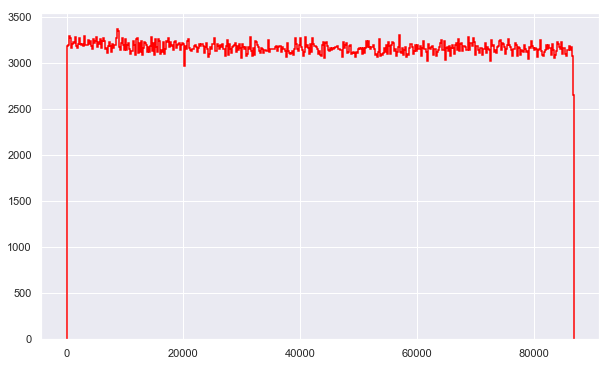

In [97]:
fig = plt.figure(figsize=(10,6))
ax      = fig.add_subplot(1, 1, 1)
(_)    = h1(kge.DT, bins=500, range = (kge.DT[0], kge.DT[-1]), color='red', stats=False, lbl='pre-sel')

## Tests

#### Function: 
```
def get_time_series(nt    : int,
                    tlast : int,
                    KRES  : KrEvent)->Tuple[List[float], List[np.array]]:
```

Returns a time series (ts) and a list of masks which are used to divide the event in time tranches.

    - nt:    number of time tranches requested
    - tlast: last time entry in the time-differences vector that keeps the length of the run in terms of time-differences wrt the initial time.
    - KRES:  An object of type kr_event (a subsection of the dst)

In [219]:
log.setLevel(logging.INFO)

In [220]:
nt = 10
t0 = time.time()

ts, masks = get_time_series(nt, DT[-1], kge)  
t1 = time.time()
print(f' get_time_series: t = {t1 -t0}')

 get_time_series: t = 0.03504014015197754


In [221]:
print(f'tlast = {DT[-1]}')
print(f'ts = {ts}, len(masks) = {len(masks)}' )

tlast = 86880.49799990654
ts = [4344.0, 13032.0, 21720.0, 30408.0, 39096.0, 47784.0, 56472.0, 65160.0, 73848.0, 82536.0], len(masks) = 10


In [222]:
lengths = [len(mask)for mask in masks]
(_) = [print (f'length of mask {i} = {l}') for i,l in enumerate(lengths)]

length of mask 0 = 1583342
length of mask 1 = 1583342
length of mask 2 = 1583342
length of mask 3 = 1583342
length of mask 4 = 1583342
length of mask 5 = 1583342
length of mask 6 = 1583342
length of mask 7 = 1583342
length of mask 8 = 1583342
length of mask 9 = 1583342


In [223]:
lcount = [np.count_nonzero(mask) for mask in masks]
(_) = [print (f'number of non zero for mask {i} = {l}') for i,l in enumerate(lcount)]

number of non zero for mask 0 = 160564
number of non zero for mask 1 = 159420
number of non zero for mask 2 = 158928
number of non zero for mask 3 = 158063
number of non zero for mask 4 = 158039
number of non zero for mask 5 = 157712
number of non zero for mask 6 = 157350
number of non zero for mask 7 = 158230
number of non zero for mask 8 = 158153
number of non zero for mask 9 = 156879


In [224]:
assert len(masks) == len(ts) == nt
assert len(masks[0]) == len(kge.X) == len(dst)
assert np.equal(lengths, len(dst) * np.ones(len(lengths))).all()

In [225]:
np.count_nonzero(lcount)

10

In [226]:
assert np.count_nonzero(lcount) == nt

### Function
```
def time_fcs(masks   : List[np.array],
             kre     : KrEvent,
             nbins_z : int,
             nbins_e : int,
             range_z : Tuple[float, float] = (100,550),
             range_e : Tuple[float, float] = (8000, 12000),
             energy  : str                 = 'S2e',
             fit     : FitType             = FitType.profile)->FitParTS:
    """Fit lifetime of a time series.

    kre    : kr_event (a subset of dst)
    masks  : select the time tranches
           : bins and ranges in z and e.
    energy : variable to be taken as the energy (S2e or Q)
    fit    : type of fit.

    """
```
The object returned by the function is:
```
@dataclass
class FitParTS:             # Fit parameters Time Series
    ts   : np.array          # contains the time series (integers expressing time differences)
    e0   : np.array          # e0 fitted in time series
    lt   : np.array
    c2   : np.array
    e0u  : np.array          # e0 error fitted in time series
    ltu  : np.array
```

In [227]:
t0 = time.time()
fps = time_fcs(ts, masks, kge, 
               nbins_z = 10,
               nbins_e = 25,
               range_z = (50, 550),
               range_e = (5000, 13500),
               energy  = 'S2e',
               fit     = FitType.profile)
t1 = time.time()
print(f' time_fcs: t = {t1 -t0}')

 time_fcs: t = 0.2606010437011719


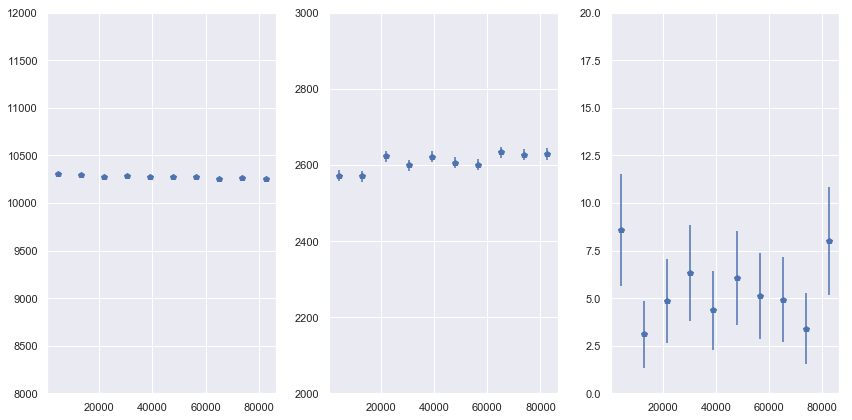

In [237]:
fig       = plt.figure(figsize=(12,6))
ax  = fig.add_subplot(1, 3, 1)
(_) = plt.errorbar(ts, fps.e0, fps.e0u, fmt="p")
plt.ylim((8000,12000))
ax  = fig.add_subplot(1, 3, 2)
(_) =plt.errorbar(ts, fps.lt, fps.ltu, fmt="p")
plt.ylim((2000,3000))
ax  = fig.add_subplot(1, 3, 3)
(_) =plt.errorbar(ts, fps.c2, sqrt(fps.c2), fmt="p")
plt.ylim((0,20))
plt.tight_layout()

##### The bad chi2 is to be expected because we are computing the average of the lifetime, which however changes considerably as a function of the spatial coordinates. In this run the average lifetime does not change much as a function of time

In [246]:
assert (fps.e0 > 10e+3).all()
assert (fps.lt > 2400).all()
assert (fps.c2 < 15).all()

In [251]:
t0 = time.time()
fps_p = time_fcs(ts, masks, kge, 
               nbins_z = 25,
               nbins_e = 50,
               range_z = (50, 550),
               range_e = (5000, 13500),
               energy  = 'S2e',
               fit     = FitType.profile)
t1 = time.time()
print(f' time_fcs: t = {t1 -t0}')

 time_fcs: t = 0.28589892387390137


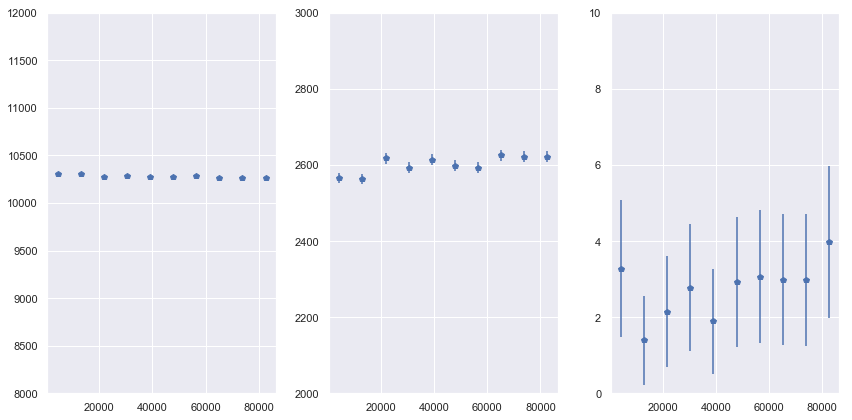

In [252]:
fps = fps_p
fig       = plt.figure(figsize=(12,6))
ax  = fig.add_subplot(1, 3, 1)
(_) = plt.errorbar(ts, fps.e0, fps.e0u, fmt="p")
plt.ylim((8000,12000))
ax  = fig.add_subplot(1, 3, 2)
(_) =plt.errorbar(ts, fps.lt, fps.ltu, fmt="p")
plt.ylim((2000,3000))
ax  = fig.add_subplot(1, 3, 3)
(_) =plt.errorbar(ts, fps.c2, sqrt(fps.c2), fmt="p")
plt.ylim((0,10))
plt.tight_layout()

##### With more energy bins, chi2 gets better and more uniform

In [253]:
t0 = time.time()
fps_u = time_fcs(ts, masks, kge, 
               nbins_z = 25,
               nbins_e = 50,
               range_z = (50, 550),
               range_e = (5000, 13500),
               energy  = 'S2e',
               fit     = FitType.unbined)
t1 = time.time()
print(f' time_fcs: t = {t1 -t0}')

 time_fcs: t = 0.44344592094421387


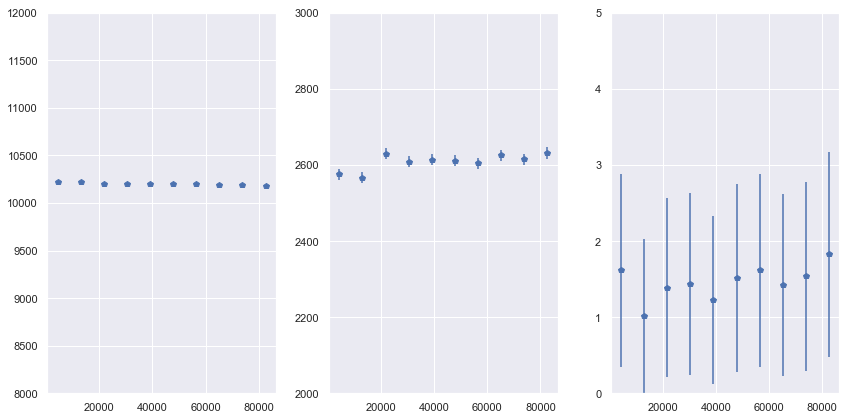

In [255]:
fps = fps_u
fig       = plt.figure(figsize=(12,6))
ax  = fig.add_subplot(1, 3, 1)
(_) = plt.errorbar(ts, fps.e0, fps.e0u, fmt="p")
plt.ylim((8000,12000))
ax  = fig.add_subplot(1, 3, 2)
(_) =plt.errorbar(ts, fps.lt, fps.ltu, fmt="p")
plt.ylim((2000,3000))
ax  = fig.add_subplot(1, 3, 3)
(_) =plt.errorbar(ts, fps.c2, sqrt(fps.c2), fmt="p")
plt.ylim((0,5))
plt.tight_layout()

In [256]:
fps_p

FitParTS(ts=array([ 4344., 13032., 21720., 30408., 39096., 47784., 56472., 65160.,
       73848., 82536.]), e0=array([10303.03553585, 10301.00938376, 10277.5470832 , 10283.55170161,
       10272.85634357, 10277.59736015, 10279.32039274, 10260.08735939,
       10262.0847353 , 10259.09477891]), lt=array([2565.34089645, 2563.05301594, 2617.89722862, 2592.36374517,
       2614.27175643, 2597.45645914, 2592.57228437, 2625.6582985 ,
       2621.3452358 , 2621.63514459]), c2=array([3.27686777, 1.38895298, 2.14799587, 2.77344831, 1.88979363,
       2.92836975, 3.05726249, 2.98580576, 2.97434523, 3.98559566]), e0u=array([7.26439984, 7.29034381, 7.34561458, 7.37212648, 7.3509653 ,
       7.37252105, 7.40749275, 7.40814787, 7.39864263, 7.47494508]), ltu=array([13.95123116, 13.998409  , 14.65461427, 14.45961518, 14.67771572,
       14.53951315, 14.57919107, 14.88537556, 14.88055258, 15.0280461 ]))

In [257]:
fps_u

FitParTS(ts=array([ 4344., 13032., 21720., 30408., 39096., 47784., 56472., 65160.,
       73848., 82536.]), e0=array([10223.47399053, 10225.22555491, 10197.06954793, 10201.25520397,
       10197.60264716, 10196.09850765, 10199.9094054 , 10185.9608983 ,
       10188.85960441, 10180.12995107]), lt=array([2575.05338275, 2566.5956004 , 2629.63903139, 2608.43715557,
       2613.78814201, 2611.66025082, 2603.96118152, 2625.29798166,
       2615.10405942, 2631.33537747]), c2=array([1.61589825, 1.01553755, 1.3858105 , 1.43465762, 1.22401269,
       1.51340338, 1.61405324, 1.42601536, 1.53469828, 1.82510689]), e0u=array([6.84599947, 6.88051007, 6.91875244, 6.93578572, 6.93420504,
       6.95732642, 6.9773066 , 6.94864933, 6.97590623, 7.01519004]), ltu=array([13.63011505, 13.6016214 , 14.35463965, 14.13696057, 14.21247582,
       14.20468514, 14.18700301, 14.37173376, 14.29384813, 14.57264644]))

In [259]:
abs((fps_p.e0 - fps_p.e0) / fps_u.e0)

array([0.00778224, 0.00741146, 0.00789222, 0.00806729, 0.00737955,
       0.00799314, 0.00778546, 0.00727732, 0.00718678, 0.00775676])

In [261]:
np.allclose(fps_p.e0, fps_p.e0, rtol=0.01)

True

In [263]:
abs((fps_p.lt - fps_u.lt) / fps_u.lt)

array([0.00377176, 0.00138027, 0.00446518, 0.00616208, 0.00018502,
       0.00543861, 0.00437368, 0.00013725, 0.00238659, 0.00368643])

In [264]:
np.allclose(fps_p.lt, fps_p.lt, rtol=0.01)

True

### Function (analysis_functions):
```
select_xy_sectors(dst        : DataFrame,
                  time_diffs : np.array,
                  E          : np.array,
                  Q          : np.array,
                  bins_x     : np.array,
                  bins_y     : np.array)-> Dict[int, List[KrEvent]]
```


In [267]:
log.setLevel(logging.DEBUG)

In [268]:
kTimes, kRanges, kNbins, kBins = kr_ranges_and_bins(dst,
                                                        xxrange   = xy_range,
                                                        yrange    = xy_range,
                                                        zrange    = z_range,
                                                        s2erange  = s2e_range,
                                                        s1erange  = s1e_range,
                                                        s2qrange  = s2q_range,
                                                        xnbins    = 5,
                                                        ynbins    = 5,
                                                        znbins    = 10,
                                                        s2enbins  = 25,
                                                        s1enbins  = 10,
                                                        s2qnbins  = 25,
                                                        tpsamples = 3600) #

In [270]:
print(f' nbins_x = {kNbins.X}, nbins_y = {kNbins.Y}')
print(f' bins_x =  {kBins.X},  bins_y = {kBins.Y}')

 nbins_x = 5, nbins_y = 5
 bins_x =  [-200. -120.  -40.   40.  120.  200.],  bins_y = [-200. -120.  -40.   40.  120.  200.]


In [271]:
t0 = time.time()
KRE = select_xy_sectors(dst, DT, dst.S2e.values, dst.S2q.values, kBins.X, kBins.Y)
t1 = time.time()
print(f' time_fcs: t = {t1 -t0}')                   

2018-09-02 21:26:56,435 | DEBUG :  function: select_xy_sectors
2018-09-02 21:26:56,436 | DEBUG :  calling selection_mask
2018-09-02 21:26:56,437 | DEBUG : computing selection mask for sector 0
2018-09-02 21:26:56,455 | DEBUG : computing selection mask for sector 1
2018-09-02 21:26:56,472 | DEBUG : computing selection mask for sector 2
2018-09-02 21:26:56,491 | DEBUG : computing selection mask for sector 3
2018-09-02 21:26:56,510 | DEBUG : computing selection mask for sector 4
2018-09-02 21:26:56,534 | DEBUG :  selection mask computed, filling selections
2018-09-02 21:26:56,535 | DEBUG :  defining kr_event for sector 0
2018-09-02 21:26:56,677 | DEBUG :  defining kr_event for sector 1
2018-09-02 21:26:56,848 | DEBUG :  defining kr_event for sector 2
2018-09-02 21:26:57,022 | DEBUG :  defining kr_event for sector 3
2018-09-02 21:26:57,187 | DEBUG :  defining kr_event for sector 4
2018-09-02 21:26:57,311 | DEBUG :  RGES computed
 time_fcs: t = 0.8876101970672607


In [273]:
neM = event_map(KRE)

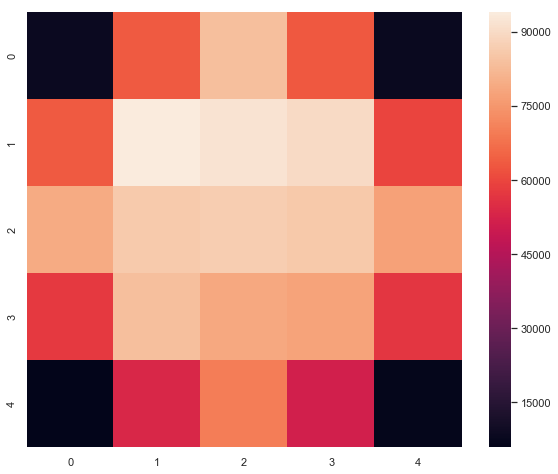

In [274]:
ax = sns.heatmap(neM, square=True)

In [275]:
neM

,0,1,2,3,4
0,8386,63278,83789,63063,8199
1,63604,93863,92090,89802,59750
2,79270,86192,86909,85937,77347
3,57746,83659,78413,77645,56875
4,5877,53407,69962,51379,6724


In [276]:
neM[0]/neM[4]

0    1.022808
1    1.064502
2    1.024862
3    1.015314
4    0.874033
dtype: float64

In [277]:
neM[1]/neM[3]

0    1.003409
1    1.045222
2    1.002967
3    1.077455
4    1.039471
dtype: float64

In [287]:
l = ((neM[0]/neM[4]).values > 0.8).all() 
r = ((neM[0]/neM[4]).values < 1.1).all()
l & r

True

### Function:
```
def fit_fcs_in_xy_bin (xybin         : Tuple[int, int],
                       selection_map : Dict[int, List[KrEvent]],
                       event_map     : DataFrame,
                       n_time_bins   : int,
                       time_diffs    : np.array,
                       nbins_z       : int,
                       nbins_e       : int,
                       range_z       : Tuple[float, float],
                       range_e       : Tuple[float, float],
                       energy        : str                 = 'S2e',
                       fit           : FitType             = FitType.profile,
                       n_min         : int                 = 100)->FitParTS:
```

In [295]:
fps_p = fit_fcs_in_xy_bin (xybin          = (2,2),
                         selection_map   = KRE,
                         event_map       = neM,
                        n_time_bins     = 1,
                        time_diffs      = DT,
                        nbins_z          = 25,
                        nbins_e          = 50,
                        range_z          =(50, 550),
                        range_e          = (5000, 13500),
                        energy           = 'S2e',
                        fit              = FitType.profile,
                        n_min            = 100)

2018-09-02 22:11:06,258 | DEBUG : function: fit_fcs_in_xy_bin
2018-09-02 22:11:06,259 | DEBUG : selection map has 5 bins in x 5 bins in y
2018-09-02 22:11:06,260 | DEBUG : function: get_time_series
2018-09-02 22:11:06,260 | DEBUG :  number of time bins = 1, t_last = 86880.49799990654
2018-09-02 22:11:06,261 | DEBUG : indx = [(0, 86880)]
2018-09-02 22:11:06,261 | DEBUG : ts = [43440.0]
2018-09-02 22:11:06,263 | DEBUG : fitting bin (2,2) with 86909 events
2018-09-02 22:11:06,267 | DEBUG : function:time_fcs 
2018-09-02 22:11:06,268 | DEBUG :  list of kre_event has length 1
2018-09-02 22:11:06,268 | DEBUG :  mask 0 has length 86909
2018-09-02 22:11:06,269 | DEBUG :  mask 0 has 86908 True elements
2018-09-02 22:11:06,270 | DEBUG :  fit_liftime 
2018-09-02 22:11:06,271 | DEBUG :  len (z) =86908, len (e) =86908 
2018-09-02 22:11:06,271 | DEBUG :  nbins_z =25, nbins_e =50 range_z =(50, 550) range_e =(5000, 13500) 
2018-09-02 22:11:06,272 | DEBUG :  fit_liftime_profile
2018-09-02 22:11:06,273 |

In [297]:
fps_u = fit_fcs_in_xy_bin (xybin          = (2,2),
                         selection_map   = KRE,
                         event_map       = neM,
                        n_time_bins     = 1,
                        time_diffs      = DT,
                        nbins_z          = 25,
                        nbins_e          = 50,
                        range_z          =(50, 550),
                        range_e          = (5000, 13500),
                        energy           = 'S2e',
                        fit              = FitType.unbined,
                        n_min            = 100)

2018-09-02 22:14:04,896 | DEBUG : function: fit_fcs_in_xy_bin
2018-09-02 22:14:04,897 | DEBUG : selection map has 5 bins in x 5 bins in y
2018-09-02 22:14:04,897 | DEBUG : function: get_time_series
2018-09-02 22:14:04,898 | DEBUG :  number of time bins = 1, t_last = 86880.49799990654
2018-09-02 22:14:04,899 | DEBUG : indx = [(0, 86880)]
2018-09-02 22:14:04,900 | DEBUG : ts = [43440.0]
2018-09-02 22:14:04,901 | DEBUG : fitting bin (2,2) with 86909 events
2018-09-02 22:14:04,904 | DEBUG : function:time_fcs 
2018-09-02 22:14:04,905 | DEBUG :  list of kre_event has length 1
2018-09-02 22:14:04,906 | DEBUG :  mask 0 has length 86909
2018-09-02 22:14:04,906 | DEBUG :  mask 0 has 86908 True elements
2018-09-02 22:14:04,906 | DEBUG :  fit_liftime 
2018-09-02 22:14:04,907 | DEBUG :  len (z) =86908, len (e) =86908 
2018-09-02 22:14:04,908 | DEBUG :  nbins_z =25, nbins_e =50 range_z =(50, 550) range_e =(5000, 13500) 
2018-09-02 22:14:04,909 | DEBUG :  fit_liftime_unbined
2018-09-02 22:14:04,910 |

In [298]:
log.setLevel(logging.INFO)

In [299]:
neM.shape

(5, 5)

In [323]:
def get_maps(fit= FitType.profile):
    pFP = {}
    
    for nx in range(neM.shape[0]):
        pFPL =[fit_fcs_in_xy_bin (xybin          = (nx,ny),
                                 selection_map   = KRE,
                                 event_map       = neM,
                                 n_time_bins     = 1,
                                 time_diffs      = DT,
                                 nbins_z         = 25,
                                 nbins_e         = 50,
                                 range_z         =(50, 550),
                                 range_e         = (5000, 13500),
                                energy           = 'S2e',
                                  fit            = fit,
                                n_min            = 100) for ny in range(neM.shape[1])]
        pFP[nx] = pFPL 
    
    pE0 = {}
    pLT = {}
    pC2 = {}
    for nx in range(neM.shape[0]):
        pE0L = [pFP[nx][ny].e0[0] for ny in range(neM.shape[1])] # notice [0] ts bin
        pLTL = [pFP[nx][ny].lt[0] for ny in range(neM.shape[1])]
        pC2L = [pFP[nx][ny].c2[0] for ny in range(neM.shape[1])]
        pE0[nx] = pE0L
        pLT[nx] = pLTL
        pC2[nx] = pC2L
    
    return pd.DataFrame.from_dict(pE0), pd.DataFrame.from_dict(pLT),pd.DataFrame.from_dict(pC2)



In [324]:
t0 = time.time()
mE0p, mLTp, mC2p = get_maps(fit= FitType.profile)
t1 = time.time()
print(f' dt = {t1 -t0}')

 dt = 0.22681927680969238


In [325]:
t0 = time.time()
mE0u, mLTu, mC2u = get_maps(fit= FitType.unbined)
t1 = time.time()
print(f' dt = {t1 -t0}')

 dt = 0.4076199531555176


In [326]:
mLTp

,0,1,2,3,4
0,2947.580039,2609.216030,2521.439358,2583.548853,2771.378316
1,2551.737036,2298.241281,2280.206687,2281.064699,2524.303344
2,2514.860936,2312.324635,2319.596409,2301.680776,2527.926725
3,2729.889193,2431.629580,2376.429515,2412.970490,2736.942339
4,3228.117789,3001.845473,2845.731932,3035.829600,3138.950379


In [327]:
mLTu

,0,1,2,3,4
0,2980.896948,2622.260828,2532.493142,2592.045930,2784.948557
1,2545.316433,2288.548216,2271.258360,2270.966506,2526.152952
2,2513.557341,2304.150122,2311.793990,2295.235259,2524.105845
3,2735.627579,2426.207961,2370.529889,2408.548274,2729.494455
4,3277.475619,3021.021177,2855.343131,3024.519157,3141.156095


In [328]:
mLTp / mLTu

,0,1,2,3,4
0,0.988823,0.995025,0.995635,0.996722,0.995127
1,1.002523,1.004235,1.003940,1.004447,0.999268
2,1.000519,1.003548,1.003375,1.002808,1.001514
3,0.997902,1.002235,1.002489,1.001836,1.002729
4,0.984940,0.993653,0.996634,1.003740,0.999298


In [329]:
mE0p / mE0u

,0,1,2,3,4
0,1.003962,1.004349,1.004854,1.004651,1.003350
1,1.003422,1.000031,0.999885,1.000590,1.003913
2,1.003373,1.000056,0.999811,1.000261,1.004177
3,1.004494,1.000798,1.000429,1.000871,1.004105
4,1.005258,1.005993,1.005968,1.005494,1.003863
